In [1]:
# DOWNLOAD AND EXTRACT INSTALLED PACKAGES WITH THEIR VERSION NUMBERS AND DEBIAN VERSION
import os
def download(image, removed):
    os.system("docker run --entrypoint '/bin/bash' "+image+" -c 'cat /etc/issue' > "+dir+file+"_issue")
    os.system("docker run --entrypoint '/bin/bash' "+image+" -c 'cat /etc/debian_version' > "+dir+file+"_debian")
    os.system("docker run --entrypoint '/bin/bash' "+image+" -c 'dpkg -l' > "+dir+file+"_dpkg")
    if removed:
        os.system("docker stop $(docker ps -a | grep '"+image+" ' | cut -d' ' -f1)")
        os.system("docker rm $(docker ps -a | grep '"+image+" ' | cut -d' ' -f1)")
        #os.system("docker rmi $(docker images | grep '"+image.split(':')[0]+" ' | grep '"+image.split(':')[0]+" ')")

In [2]:
# PARSE INSTALLED PACKAGES WITH THEIR VERSION NUMBERS AND DEBIAN VERSION
import json as js
import os
import codecs
import subprocess
import pandas as pd

# get packages and their versions found installed in countainers; from "dpkg -l" files

def parse_packages(dir,file):
    columns=['name','package','version']
    data = pd.DataFrame(columns=columns)
    command_package="grep ^ii "+dir+file+"_dpkg" # sed 's/  */ /g' | 

    proc = subprocess.Popen(command_package, stdout=subprocess.PIPE, shell=True)
    lines = list(filter(lambda x:len(x)>0,(line.strip().decode('utf-8') for line in proc.stdout)))
    packages=[]
    versions=[]
    for line in lines:
        line=line.split(' ')
        line=sorted(set(line), key=lambda x: line.index(x))
        packages.append(line[2])
        versions.append(line[3])

    df = pd.DataFrame({'name':file, 'package':packages,'version':versions})
    data=data.append(df)
    return data.set_index('name')


def parse_release(dir,file):
    with open(dir+file+"_debian") as lines:
        for line in lines.readlines():
            release=line.strip('\n')
    return release

def parse_debian(dir, file):
    installed_packages=parse_packages(dir,file)
    installed_packages['release_number']=parse_release(dir,file)
    
    installed_packages['debian']=installed_packages['release_number'].apply(lambda x:
                                                               'jessie' if x.startswith('8')
                                                               else 'stretch' if x.startswith('9')
                                                               else 'wheezy' if x.startswith('7')
                                                               else 'squeeze' if x.startswith('6')
                                                               else 'buster' if x.startswith('buster')
                                                                else x)
    installed_packages['package']=installed_packages['package'].apply(lambda x: x.split(':')[0])

    installed_packages.drop_duplicates(inplace=True)
    
    return installed_packages

In [3]:
###### TRACK THE PACKAGES
def debian_packages():
    debian_packages=pd.read_csv('../data_docker//debian_packages_18March.csv', sep=';', dtype=object, index_col=None,  error_bad_lines=False)
    return debian_packages

def track_packages(installled_packages):
    debian_p=debian_packages()
    
    tracked_packages=(installled_packages.
                      set_index(['package','version']).
                      merge(debian_p.
                            set_index(['package','version']),
                            left_index=True, 
                            right_index=True, 
                            how='outer')
                     ).reset_index().dropna() 
    ##### OR, 
        # .fillna('0')
        # tracked_packages=tracked_packages.query('release_number!="0"')
    for column in['last_order', 'version_order']:
        tracked_packages[column]=tracked_packages[column].apply(int)
    tracked_packages['outdate']=tracked_packages['last_order']-tracked_packages['version_order']
    return tracked_packages
    

In [4]:
################# IDENTIFY VULNERABIITIES
################# version where the vulnerability was fixed > version used


import json as js
import codecs
import apt_pkg
apt_pkg.init_system()

def parse_json_vuls():
    vulnerabilities=js.load(codecs.open('../data_docker/vuls_15April.json', 'r', 'utf-8'))
    return vulnerabilities

def dates_release_debian():
    debian_p=debian_packages()
    df_packages=(debian_p.
                 sort_values('date', ascending=True).
                 groupby(['source','source_version','release_snapshot']).
                 first().
                 drop(['package','version'], axis=1)
                )

    dict_date=df_packages.to_dict() ### dict of source version dates

    df_packages_release=(debian_p.
                         sort_values('date', ascending=True).
                         groupby(['source','source_version']).
                         first().
                         drop(['package','version','date'], axis=1)
                        )

    dict_release=df_packages_release.to_dict() # dict of releases
    return dict_date, dict_release

def unique_installed_packages(tracked_packages):
    df=(tracked_packages. ######## We create a DF with source packages found in Docker containers
        groupby(['source','source_version']).
        count().
        drop(['package','version'], axis=1).
        reset_index()
       ) ######## only source versions and distinct.
    
    return df

def final_vuls(tracked_packages):
    
    vulnerabilities=parse_json_vuls()
    
    dict_date, dict_release = dates_release_debian()
    
    sorted_ip=unique_installed_packages(tracked_packages)
    
    
    fcsv=open('../data_docker/docker_vulnerabilities.csv','w')
    fcsv.write('source;source_version;urgency;status;fixed_version;debianbug;release;cve\n')

    for index, raw in enumerate(sorted_ip.iterrows()): ######## we iterate over the sources (docker)
        source=raw[1]['source']
        source_version=raw[1]['source_version']
        release=dict_release['release_snapshot'][(source, source_version)]
        date_source=dict_date['date'][(source, source_version,release)]
        try:
            vuls=vulnerabilities[source] ###### check if the source has any vulnerabilities
        except:
            continue
        for cve in vuls:  ###### for each vulnerability
            if not cve.startswith('CVE'):
                continue
            #if cve.split('-')[1] > date_source[0:4]:
            #    continue
            v=vulnerabilities[source][cve]
            try:
                status=v['releases'][release]['status']  ###### check only the release of source
                urgency=v['releases'][release]['urgency'] ###### check only the release of source

                try:
                    debianbug=str(v['debianbug'])
                except:
                    debianbug="undefined"

                if status == "open" or status=="undetermined": ###### if the vulnerability is still OPEN
                    fixed="undefined"
                    fcsv.write(source+';'+source_version+';'+urgency+';'+status+';'+fixed+';'+debianbug+';'+release+';'+cve+'\n')
                else: ###### if the vulnerability is RESOLVED
                    try:
                        fixed=v['releases'][release]["fixed_version"]
                    except:
                        continue
                    #try:
                        #date_fixed=dict_date['date'][(source, fixed,release)]
                    if apt_pkg.version_compare(source_version,fixed) < 0: #### Compare between the used source and fixed one (dates comparison)
                        fcsv.write(source+';'+source_version+';'+urgency+';'+status+';'+fixed+';'+debianbug+';'+release+';'+cve+'\n')
                    #except:
                    #    if compare_versions(source_version,fixed,'fixed'):
                     #       fcsv.write(source+';'+source_version+';'+urgency+';'+status+';'+fixed+';'+debianbug+';'+release+';'+cve+'\n')
                            
            except:
                pass
    fcsv.close()
    
def get_vuls(tracked_packages):
    final_vuls(tracked_packages)
    
    docker_vulnerabilities=pd.read_csv('../data_docker/docker_vulnerabilities.csv', sep=';', dtype=object, index_col=None,  error_bad_lines=False)
    docker_vulnerabilities.drop_duplicates(inplace=True)
    
    return docker_vulnerabilities

In [5]:
#### MERGE FOUND VULNERABILITIES WITH INSTALLED PACKAGES
def merge_vuls(tracked_packages):
    vuls=get_vuls(tracked_packages)            ### GET VULNERABILITIES
    # Here we merge vulnerabilities with community outdated packages
    docker_vuls=(
        tracked_packages.
        set_index(['source','source_version']).
        merge(vuls.
              set_index(['source','source_version']),
              left_index=True, 
              right_index=True, 
              how='outer').dropna().reset_index().drop_duplicates()
    )
    return docker_vuls

In [6]:
########## HERE WE EXTRACT BUGS FROM UDD ###############
import json as js
import os
import codecs
import psycopg2
import pandas as pd

def connexion_udd():
        conn_string="host='udd-mirror.debian.net' port='5432' dbname='udd' user='udd-mirror' password='udd-mirror'"
        conn = psycopg2.connect(conn_string)
        conn.set_client_encoding('UTF8')
        cursor = conn.cursor()
        return cursor
    
def extract_bugs_from_udd(tracked_packages, bugs_notProcessed):

    if not os.path.isfile(bugs_notProcessed): #### just for now

        cursor=connexion_udd()
        
        uniq_packages=tracked_packages.groupby('source').count().loc[:,[]].reset_index()

        f=open(bugs_notProcessed,'w')
        f.write('source;debianbug;found_in;fixed_in;type;status;severity;arrival;last_modified\n')

        for index, raw in enumerate(uniq_packages.iterrows()):
            source=raw[1]['source']

            # print(index,package)

            cursor.execute(
                "SELECT DISTINCT bugs.id, bugs.status, bugs.severity, "+
                "bugs.arrival, bugs.last_modified, bugs_found_in.version, bugs_fixed_in.version "+
                "FROM bugs_found_in, bugs LEFT JOIN bugs_fixed_in "+
                "ON bugs.id=bugs_fixed_in.id "+
                "WHERE bugs.id=bugs_found_in.id "+
                "AND bugs.source='"+source+"' ")
            data=cursor.fetchall()
            for x in data:
                id, status, severity, arrival, last_modified, found_in, fixed_in = x
                f.write(source+';'+str(id)+';'+found_in+';'+str(fixed_in)+';normal;'+status+';'+severity+';'+str(arrival)+';'+str(last_modified)+'\n')

            cursor.execute(
            "SELECT DISTINCT archived_bugs.id, archived_bugs.status, archived_bugs.severity, "+
            "archived_bugs.arrival, archived_bugs.last_modified, "+
            "archived_bugs_found_in.version, archived_bugs_fixed_in.version "+
            "FROM archived_bugs_found_in, archived_bugs LEFT JOIN archived_bugs_fixed_in "+
            "ON archived_bugs.id=archived_bugs_fixed_in.id "+
            "WHERE archived_bugs.id=archived_bugs_found_in.id "+
            "AND archived_bugs.source='"+source+"'")
            data2=cursor.fetchall()
            for x in data2:
                id, status, severity, arrival, last_modified, found_in, fixed_in = x
                f.write(source+';'+str(id)+';'+found_in+';'+str(fixed_in)+';archived;'+status+';'+severity+';'+str(arrival)+';'+str(last_modified)+'\n')

            # print(len(data),len(data2))

        f.close()


In [7]:
################# We identify which sources versions are affected by the bugs #########""

################# version where bug found <= version used < version where the bug was fixed

def get_bugs(tracked_packages):
    
    bugs_notProcessed='../data_docker//bugs_notProcessed_'+file+'.csv'

    extract_bugs_from_udd(tracked_packages, bugs_notProcessed)

    bugs=pd.read_csv(bugs_notProcessed, sep=';', dtype=object, index_col=None,  error_bad_lines=False)
    bugs.drop_duplicates(inplace=True)

    bugs['fixed_in']=bugs['fixed_in'].apply(lambda x: str(x).split('/')[-1])
    bugs['found_in']=bugs['found_in'].apply(lambda x: str(x).split('/')[-1])

    sources=tracked_packages.groupby(['source','source_version','release_snapshot','date']).count().loc[:,[]].reset_index()
    deb_packages=debian_packages()
    bugs=(bugs.
          set_index(['source']).
          merge(sources.
                set_index(['source']),
                left_index=True, 
                right_index=True, 
                how='left').dropna().reset_index()
         )

    bugs=(bugs.
          set_index(['source','found_in']).
          merge(deb_packages.
                rename(columns={'date':'date_found','source_version':'found_in'}).
                set_index(['source','found_in']),
                left_index=True, 
                right_index=True, 
                how='left').dropna().reset_index().drop_duplicates()
         )


    bugs['filtre']=bugs.apply(lambda row: True if apt_pkg.version_compare(str(row['found_in']), str(row['source_version']))<=0
                              else False, axis=1)

    bugs=bugs.query('filtre==True') # date_found<=date and 

    bugs=(bugs.
          set_index(['source','fixed_in']).
          merge(deb_packages.
                rename(columns={'date':'date_fixed','source_version':'fixed_in'}).
                set_index(['source','fixed_in']),
                left_index=True, 
                right_index=True, 
                how='left').fillna('undefined').reset_index().drop_duplicates()
         )
    deb_packages==debian_packages()
    bugs['filtre']=bugs.apply(lambda row: True if apt_pkg.version_compare(str(row['source_version']), str(row['fixed_in']))<0
                              else False, axis=1)
    
    bugs=bugs.query('filtre==True') # date_fixed>date 

    bugs=bugs.groupby(['debianbug','source']).first().reset_index()

    return bugs

In [8]:
####### HERE WE GET GENERAL INFOR from the repo

import requests

def general_information(image):

    if ':' in image:
        slug=image.split(':')[0]
        tag=str(image.split(':')[1])
    else:
        slug=image
        tag='latest'

    if '/' in slug:
        url='https://registry.hub.docker.com/v2/repositories/'+slug
        slug_info = requests.get(url=url).json()
        url='https://registry.hub.docker.com/v2/repositories/'+slug+'/tags/'+tag
        tag_info = requests.get(url=url).json()

    else:
        url='https://registry.hub.docker.com/v2/repositories/library/'+slug
        slug_info = requests.get(url=url).json()
        url='https://registry.hub.docker.com/v2/repositories/library/'+slug+'/tags/'+tag
        tag_info = requests.get(url=url).json()

    results={}
    results['description']=slug_info['description']
    results['star_count']=str(slug_info['star_count'])
    results['pull_count']=str(slug_info['pull_count'])
    results['full_size']=str(tag_info['full_size'])
    results['last_updated']=tag_info['last_updated']
    results['architectures']=[a['architecture'] for a in tag_info['images']]
    return results
    

In [11]:
# HERE CONFIGGURATION
#image="grimoirelab/perceval"
#image="jvgoing/api"
image="debian:buster-slim"
removed=True
dir="../data_docker//"
file=image.replace('/','_')

In [12]:
####### PROCESS #######
download(image,removed)            ### DOWNLOAD THE IMAGES

installed_packages=parse_debian(dir,file)             ### GET THE INSTALLED PACKAGES

tracked_packages=track_packages(installed_packages)            ### TRACK THE INSTALLED PACKAGES

if True:
    docker_vuls=merge_vuls(tracked_packages)

    bugs=get_bugs(tracked_packages)

    general_info=general_information(image)

    print('# installed packages', len(installed_packages))
    print('# tracked packages', len(tracked_packages))
    print('# vulnerabilities', len(docker_vuls))
    print('# bugs', len(bugs))
    general_info

# installed packages 84
# tracked packages 11
# vulnerabilities 0
# bugs 73


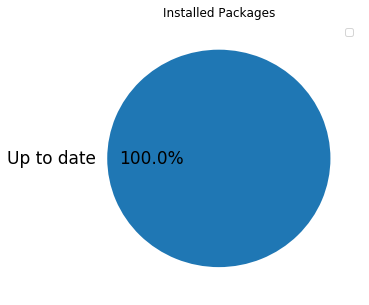

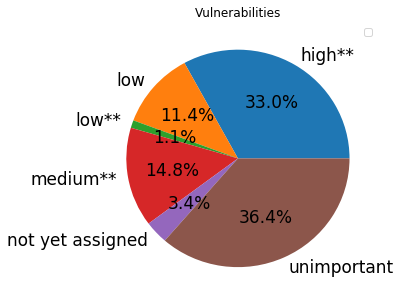

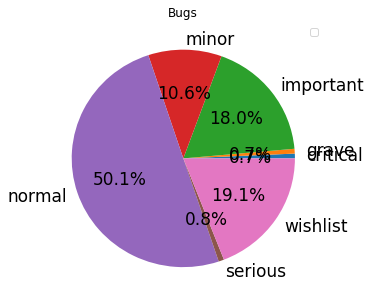

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

tracked_packages['isOutdate']=tracked_packages['outdate'].apply(lambda x: 'Up to date' if x==0
                                                               else 'Out of date')

ax=tracked_packages.groupby('isOutdate').count().plot(kind='pie',
                                                      autopct='%1.1f%%',
                                                      y='source', 
                                                      title='Installed Packages',  
                                                      fontsize=17)#, explode=explode)

ax.legend('')
ax.set_ylabel('')
ax.tick_params(labelsize=30, width=4)
ax.figure.set_size_inches(5,5)

ax=docker_vuls.groupby('urgency').count().plot(kind='pie',
                                               autopct='%1.1f%%',
                                               y='source', 
                                               title='Vulnerabilities',
                                               fontsize=17)#, explode=explode)

ax.legend('')
ax.set_ylabel('')
ax.tick_params(labelsize=30, width=4)
ax.figure.set_size_inches(5,5)

ax=bugs.groupby('severity').count().plot(kind='pie',
                                         autopct='%1.1f%%',
                                         y='source', 
                                         title='Bugs', 
                                         fontsize=17)#, explode=explode)

ax.legend('')
ax.set_ylabel('')
ax.tick_params(labelsize=30, width=4)
ax.figure.set_size_inches(5,5)